In [20]:
import sys, os
import glob
import pandas as pd
import numpy as np
from pathlib import Path

sys.path.append('../src/')
from count_datasets import CountDataset, CountGridDataset
from count_datasets import load_count_dataset, load_count_grid_dataset, read_annotated_starray
from multimodal_datasets import MultiModalDataset, MultiModalGridDataset

import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
# Paths to count, image data
data_dir = '/mnt/home/adaly/ceph/datasets/BA44/'

meta = pd.read_csv(os.path.join(data_dir, 'Splotch_Metadata.tsv'), sep='\t', header=0)

count_files = [os.path.join(data_dir, cfile) for cfile in meta['Count file']]
image_files = [os.path.join(data_dir, ifile.replace('HE', 'HE_ccast')) for ifile in meta['Image file']]
annot_files = [os.path.join(data_dir, afile.replace('annotations', 'annotations_splotch')).replace('csv', 'tsv') for afile in meta['Annotation file']]

count_files_pp = [os.path.join(data_dir, 'countfiles_norm', Path(cf).name) for cf in count_files]

In [24]:
# Pre-process count data
from anndata import AnnData
from scanpy.pp import normalize_total, filter_cells, log1p

for infile, outfile in zip(count_files, count_files_pp):
    df = pd.read_csv(infile, sep='\t', header=0, index_col=0)
    genes = pd.DataFrame(index=df.index)
    spots = pd.DataFrame(index=df.columns)
    adat = AnnData(X=df.values.T, obs=spots, var=genes)
    
    filter_cells(adat, min_counts=100)                                    # Remove spots with <100 UMIs
    normalize_total(adat, target_sum=1e6, exclude_highly_expressed=True)  # CPM normalization
    log1p(adat)                                                           # log(x+1)-transform counts
    cmat = adat.X.T / np.log(1e6)                                         # Scale data between [0,1]
    
    df_pp = pd.DataFrame(cmat, index=adat.var.index, columns=adat.obs.index)
    df_pp.to_csv(outfile, sep='\t')

(78, 64, 14) (78, 64)
['Layer_1' 'Layer_2' 'Layer_3' 'Layer_4' 'Layer_5' 'Layer_6' 'Pia'
 'White_matter'] 0 8


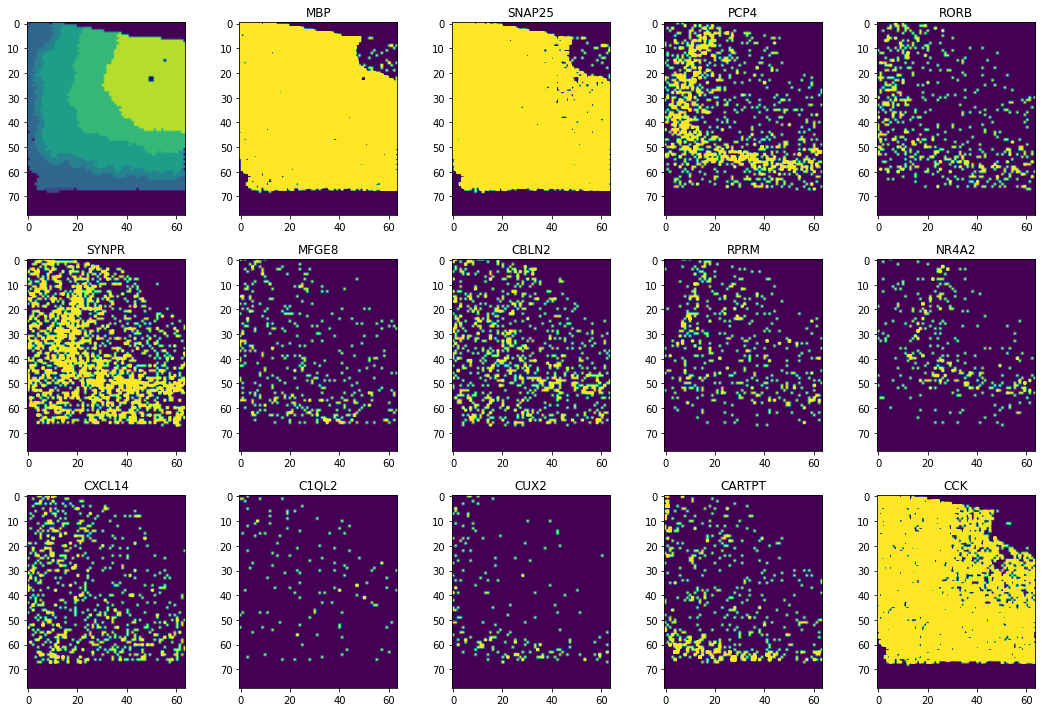

In [10]:
# Joana's manually curated list of layer marker genes:
jp_markers = {
    'MBP': 'ENSG00000197971.16',    # WM
    'SNAP25': 'ENSG00000132639.13', # GM (Layers 1-6)
    'PCP4': 'ENSG00000183036.11',   # Layer 5
    'RORB': 'ENSG00000198963.11',   # Layer 4
    'SYNPR': 'ENSG00000163630.11',  # Layer 6
    'MFGE8': 'ENSG00000140545.15',
    'CBLN2': 'ENSG00000141668.10',
    'RPRM': 'ENSG00000177519.4',
    'NR4A2': 'ENSG00000153234.15',
    'CXCL14': 'ENSG00000145824.13',
    'C1QL2': 'ENSG00000144119.4',
    'CUX2': 'ENSG00000111249.14',
    'CARTPT': 'ENSG00000164326.5',
    'CCK': 'ENSG00000187094.12'
}

counts_grid, annots_grid, gene_names, annot_names = read_annotated_starray(
    count_files_pp[4], annot_files[4], select_genes = [x for _,x in jp_markers.items()])
print(counts_grid.shape, annots_grid.shape)
print(annot_names, annots_grid.min(), annots_grid.max())

fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(3,5,1)
ax.imshow(annots_grid, vmin=0, vmax=len(annot_names)+1)

for i, (cname, ensmbl) in enumerate(jp_markers.items()):
    ax = fig.add_subplot(3,5,i+2)
    ax.imshow(counts_grid[:,:,np.where(gene_names==ensmbl)[0][0]], vmin=0, vmax=1)
    ax.set_title(cname)
    
plt.tight_layout()
plt.show()